In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

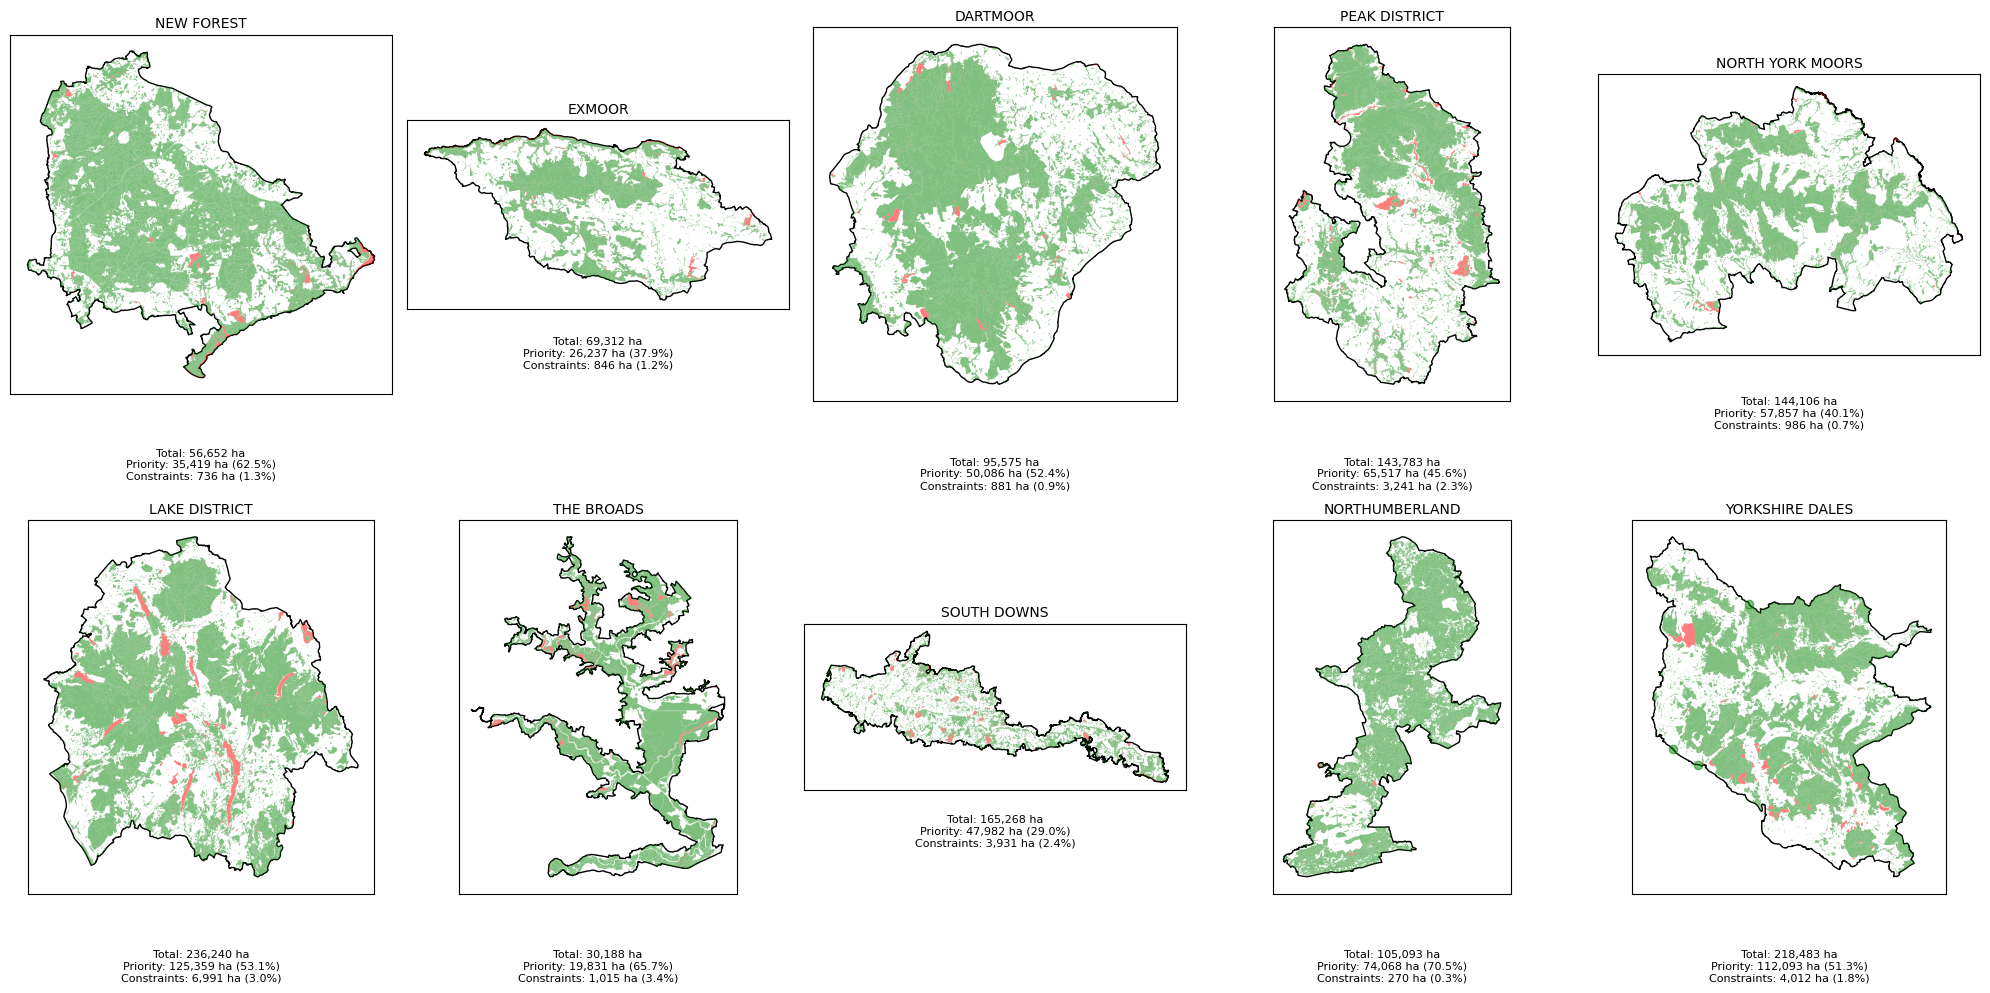

In [6]:
# File paths
boundary_path = "../data/boundaries/National_Parks_England/National_Parks_(England)___Natural_England.shp"
priority_habitats_path = "../data/outputs/clipped/priority_habitats_clipped.shp"
constraints_matrix_path = "../data/outputs/constraints_matrix/constraints_matrix_no_habitats.shp"

# Load GeoDataFrames
boundary_gdf = gpd.read_file(boundary_path).to_crs(epsg=27700)
priority_habitats_gdf = gpd.read_file(priority_habitats_path).to_crs(epsg=27700)
constraints_matrix_gdf = gpd.read_file(constraints_matrix_path).to_crs(epsg=27700)

# Add area calculation to each National Park
boundary_gdf["area_ha"] = boundary_gdf.geometry.area / 10000  # Convert to hectares

# Initialize a DataFrame to store areas
area_stats = []

# Loop through each National Park
for _, park in boundary_gdf.iterrows():
    park_geom = park.geometry
    park_name = park["NAME"]  # Adjust based on actual column name

    # Clip and calculate areas for Priority Habitats
    priority_clip = gpd.clip(priority_habitats_gdf, park_geom)
    priority_area_ha = priority_clip.geometry.area.sum() / 10000

    # Clip and calculate areas for Constraints Matrix
    constraints_clip = gpd.clip(constraints_matrix_gdf, park_geom)
    constraints_area_ha = constraints_clip.geometry.area.sum() / 10000

    # Append stats
    area_stats.append({
        "park_name": park_name,
        "total_area_ha": park["area_ha"],
        "priority_area_ha": priority_area_ha,
        "constraints_area_ha": constraints_area_ha,
        "priority_pct": (priority_area_ha / park["area_ha"]) * 100,
        "constraints_pct": (constraints_area_ha / park["area_ha"]) * 100
    })

# Convert area stats to a DataFrame
area_stats_df = pd.DataFrame(area_stats)

# Save stats to a CSV file
area_stats_df.to_csv("../output/national_parks_area_stats.csv", index=False)

# Plot National Parks with Subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
axes = axes.flatten()

for idx, (ax, park) in enumerate(zip(axes, boundary_gdf.iterrows())):
    _, park_data = park
    park_geom = park_data.geometry
    park_name = park_data["NAME"]

    # Plot the park boundary
    gpd.GeoSeries(park_geom).plot(ax=ax, color="none", edgecolor="black", linewidth=1)

    # Clip and plot priority habitats and constraints matrix
    gpd.clip(priority_habitats_gdf, park_geom).plot(ax=ax, color="green", alpha=0.5)
    gpd.clip(constraints_matrix_gdf, park_geom).plot(ax=ax, color="red", alpha=0.5)

    # Remove x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Add title and stats below each subplot
    stats = area_stats_df[area_stats_df["park_name"] == park_name]
    annotation = (
        f"Total: {stats['total_area_ha'].values[0]:,.0f} ha\n"
        f"Priority: {stats['priority_area_ha'].values[0]:,.0f} ha "
        f"({stats['priority_pct'].values[0]:.1f}%)\n"
        f"Constraints: {stats['constraints_area_ha'].values[0]:,.0f} ha "
        f"({stats['constraints_pct'].values[0]:.1f}%)"
    )
    ax.set_title(park_name, fontsize=10, pad=5)
    ax.text(
        0.5, -0.15,  # Adjusted position for consistent placement
        annotation,
        fontsize=8, ha="center", va="top", transform=ax.transAxes
    )

# Remove unused subplots if any
for idx in range(len(boundary_gdf), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("../output/national_parks_with_stats.png", dpi=300)
plt.show()